# Using neural networks for L96 parameterization

In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from sklearn.metrics import r2_score
from torch import nn, optim
from torch.autograd import Variable
from torch_lr_finder import LRFinder

np.random.seed(14)  # For reproducibility
torch.manual_seed(14);  # For reproducibility

In [2]:
from L96_model import (
    L96,
    RK2,
    RK4,
    EulerFwd,
    L96_eq1_xdot,
    integrate_L96_2t,
)

[Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved) describes a "two time-scale" model in two equations (2 and 3) which are:
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
\\
\frac{d}{dt} Y_{j,k}
&= - cbY_{j+1,k} \left( Y_{j+2,k} - X_{j-1,k} \right) - c Y_{j,k} + \frac{hc}{b} X_k
\end{align}


### Create GCM classes with and without neural network parameterization

In [3]:
time_method = RK4

In [4]:
# - a GCM class without any parameterization
class GCM_no_param:
    def __init__(self, F, time_stepping=time_method):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [5]:
# - a GCM class including a linear parameterization in rhs of equation for tendency
class GCM:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) - self.parameterization(param, X)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [6]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0)).double()
        return L96_eq1_xdot(X, self.F) + np.squeeze(
            self.network(X_torch).data.numpy()
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [7]:
time_steps = 20000
Forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=Forcing)

#### Getting training data (input output pairs): 

In [8]:
# Get training data for the neural network.

# - Run the true state and output subgrid tendencies (the effect of Y on X is xytrue):
Xtrue, _, _, xytrue = W.run(dt, T, store=True, return_coupling=True)
gcm_no_param = GCM_no_param(Forcing)

#### Split to train and test (validation) data:

In [9]:
val_size = 4000  # number of time steps for validation


# train:
Xtrue_train = Xtrue[
    :-val_size, :
]  # Flatten because we first use single input as a sample
subgrid_tend_train = xytrue[:-val_size, :]

# test:
Xtrue_test = Xtrue[-val_size:, :]
subgrid_tend_test = xytrue[-val_size:, :]

## Using data loaders 

- ### Dataset and Dataloader classes provide a very convenient way of iterating over a dataset while training your machine learning model.

- ### We need to iterate over the data because it is very slow and memory intensive to hold all the data and to use gradient decent over all the data simultaneously (see more details [here](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) and [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html))

<!-- This provides a very convenient way of separating the data preparation part from the training procedure.  -->

In [10]:
# Define a data loader

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
local_torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.reshape(Xtrue_train, -1)).double(),
    torch.from_numpy(np.reshape(subgrid_tend_train, -1)).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader_local = Data.DataLoader(
    dataset=local_torch_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [11]:
# Define a test dataloader

local_torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.reshape(Xtrue_test, -1)).double(),
    torch.from_numpy(np.reshape(subgrid_tend_test, -1)).double(),
)

loader_local_test = Data.DataLoader(
    dataset=local_torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

tensor([ 9.1964,  7.8756, -0.7173,  ...,  7.5822, -1.0573,  2.9661],
       dtype=torch.float64)
tensor([-9.0178, -7.6704,  1.6742,  ..., -8.4749,  0.4958, -2.6227],
       dtype=torch.float64)


Text(0, 0.5, 'subgrid tendency')

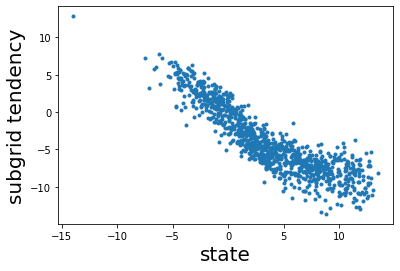

In [12]:
dataiter = iter(loader_local)  # iterating over the data to get one batch
X_iter, subgrid_tend_iter = dataiter.next()

print(X_iter)
print(subgrid_tend_iter)

fontsize = 20
plt.plot(X_iter, subgrid_tend_iter, ".")
plt.xlabel("state", fontsize=fontsize)
plt.ylabel("subgrid tendency", fontsize=fontsize)

### Define network structure in pytorch 
If you want to learn more:

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

- ### Neural networks can have many different structures.
- #### Here we will consider fully connected networks
- #### To undersand fully connected networks, we only need to understand Linear regression (and gradient descent).



<img
src="https://miro.medium.com/max/720/1*VHOUViL8dHGfvxCsswPv-Q.png" width=400>



### First we will build a linear regression 'network' and later see how to generalize the linear regression in order to use Fully connected neural network. 

In [13]:
# define a network structure in pytorch (here it is a linear network)
class linear_reg(nn.Module):
    def __init__(self):
        super(linear_reg, self).__init__()
        self.linear1 = nn.Linear(1, 1)  # a single input and a single output

    def forward(
        self, x
    ):  # when calling the model ('linear_reg(input)') it calls automatically the forward method we defined (via __call__ - see https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487)
        x = self.linear1(x)
        return x

In [14]:
lin_net = linear_reg().double()
print(lin_net)

linear_reg(
  (linear1): Linear(in_features=1, out_features=1, bias=True)
)


### Using the nework to get a prediction


In [15]:
# An example of how to plug a sample into the network
input1 = torch.randn(1, 1).double()
out = lin_net(input1)
# when calling the model ('lin_net(input)') it calls automatically the forward method we defined (via __call__ - see https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487)
print("The output of the random input is:", out.detach().numpy())

The output of the random input is: [[-0.31631446]]


### To adjust (optimize) the weights we need to define a loss function

In [16]:
criterion = torch.nn.MSELoss()  # MSE loss function
X_tmp = next(iter(loader_local))

y_tmp = lin_net(torch.unsqueeze(X_tmp[0], 1))  # Predict
loss = criterion(y_tmp, torch.unsqueeze(X_tmp[1], 1))  # calculate the MSE loss loss

### Calculating gradients

In [17]:
lin_net.zero_grad()  # zeroes the gradient buffers of all parameters

print("conv1.bias.grad before backward")
print(lin_net.linear1.bias.grad)

loss.backward(
    retain_graph=True
)  # Computes the gradient of all components current tensor

print("conv1.bias.grad after backward")
print(lin_net.linear1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([11.8117], dtype=torch.float64)


### Updating the weights using optimizer (basically built in methods for optimization such as SGD, Adam and etc.)

In [18]:
optimizer = optim.SGD(lin_net.parameters(), lr=0.003, momentum=0.9)
print("Before backward pass: \n", list(lin_net.parameters())[0].data.numpy())
loss.backward(retain_graph=True)
optimizer.step()
print("After backward pass: \n", list(lin_net.parameters())[0].data.numpy())

Before backward pass: 
 [[0.65899515]]
After backward pass: 
 [[-8.23004046e-05]]


it’s crucial you choose the correct learning rate as otherwise your network will either fail to train, or take much longer to converge. [Here](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) you can read more about the momentum term in SGD.

### The  effective value of the gradient (V) at step t in SGD with momentum ($\beta$):
### $V_t = \beta V_{t-1} + (1-\beta) \nabla_w L(W,X,y)$

### and the updates to the weights will be:
### $w^{new} = w^{old} - LR * V_t$

## Using - Adam (an adaptive learning rate optimization algorithm)

The choice of which optimizer we choose might be very important. It will determine how fast the network will be able to learn. Adam is a very popular choice (read more [here](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) about Adam, and [here](https://ruder.io/optimizing-gradient-descent/index.html#adam) about many types of different optimizers). 

#### Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters.


## Combining it all together:  training the whole network

In [19]:
def train_model(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


#         test_loss = test_loss + loss.data.numpy() # Keep track of the loss for convenience
#     test_loss /= len(trainloader) # dividing by the number of batches
#     print('the loss in this Epoch',test_loss)
#     print(b_y.shape)
#     print(prediction.shape)

In [20]:
def test_model(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss

In [21]:
n_epochs = 3  # Number of epocs (the number of times we iterate over the training data during training)
optimizer = optim.Adam(
    lin_net.parameters(), lr=0.03
)  # If we have time we can discuss later the Adam optimizer
for epoch in range(1, n_epochs + 1):
    train_model(lin_net, criterion, loader_local, optimizer)
    test_model(lin_net, criterion, loader_local, optimizer, "train")
    test_model(lin_net, criterion, loader_local_test, optimizer)

train loss: 4.019272684610542
validation loss: 4.016884708221506
train loss: 3.996398879250429
validation loss: 4.011311393860588
train loss: 4.001460134656614
validation loss: 4.024229263324334


In [22]:
print(lin_net.linear1.weight.data.numpy())
print(lin_net.linear1.bias.data.numpy())

[[-0.85304282]]
[-0.76035674]


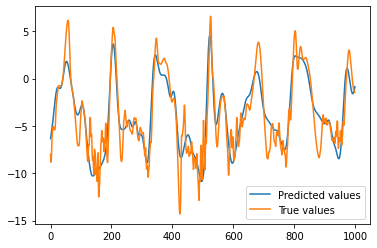

In [23]:
preds22 = lin_net(
    torch.unsqueeze(torch.from_numpy(np.reshape(Xtrue_test[:, 1], -1)).double(), 1)
)
plt.plot(preds22.detach().numpy()[0:1000], label="Predicted values")
plt.plot(subgrid_tend_test[:1000, 1], label="True values")

plt.legend();

In [24]:
T_test = 10

X_full, _, _ = W.run(dt, T_test)  # Full model


init_cond = Xtrue[-1, :]

gcm_net = GCM_network(Forcing, lin_net)
Xnn_1layer, t = gcm_net(init_cond, dt, int(T_test / dt), lin_net)

gcm_no_param = GCM_no_param(Forcing)
X_no_param, t = gcm_no_param(init_cond, dt, int(T_test / dt))


naive_parameterization = lambda param, X: np.polyval(param, X)
gcm = GCM(Forcing, naive_parameterization)
X_param, t = gcm(init_cond, dt, int(T / dt), param=[0.85439536, 1.75218026])

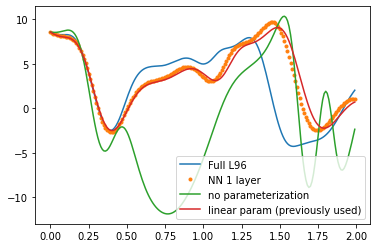

In [25]:
time_i = 200
plt.plot(t[:time_i], X_full[:time_i, 4], label="Full L96")
plt.plot(t[:time_i], Xnn_1layer[:time_i, 4], ".", label="NN 1 layer")
plt.plot(t[:time_i], X_no_param[:time_i, 4], label="no parameterization")
plt.plot(t[:time_i], X_param[:time_i, 4], label="linear param (previously used)")

plt.legend();

# Using a deeper network  for the Lorenz96  (and using non local features)

<img src="https://www.researchgate.net/publication/319201436/figure/fig1/AS:869115023589376@1584224577926/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values.png" width=400> *Fig. 1: Visualisation of a two-scale Lorenz '96 system with J = 8 and K = 6. Global-scale values (X k ) are updated based on neighbouring values and a reduction applied to the local-scale values (Y j,k ) associated with that value. Local-scale values are updated based on neighbouring values and the associated global-scale value. The neighbourhood topology of both the local and global-scale values is circular. Image from [Exploiting the chaotic behaviour of atmospheric models with reconfigurable architectures - Scientific Figure on ResearchGate.](https://www.researchgate.net/figure/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values_fig1_319201436)*



## Create non-local train/test data sets (8 inputs, 8 outputs)

In [26]:
# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(Xtrue_train).double(),
    torch.from_numpy(subgrid_tend_train).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(Xtrue_test).double(), torch.from_numpy(subgrid_tend_test).double()
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

## Creating a class of a 3 layer fully-connected network

In [28]:
# define network structure in pytorch
import torch.nn.functional as FF


class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

    #         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

## Activation function - ReLU (a popular choice)

### If layers would contain only matrix multiplication, everything would be linear: 
- ### e.g., 2 layers of weight matrices  A and B (x is the input) would give $A(Bx)$, which is linear (in x)
- ### Therefore we need to introduce some non-linearity (activation function). 
- ### The Neural Network with 2 layers of weight matrices  A and B is actually:
### $A(\phi(Bx))$ where $\phi$ is an actication function


The ReLu ativation function is just the max(0,X) - and this what is enabling the NN to be a nonlinear function of the inputs!

Text(0.5, 1.0, 'ReLU')

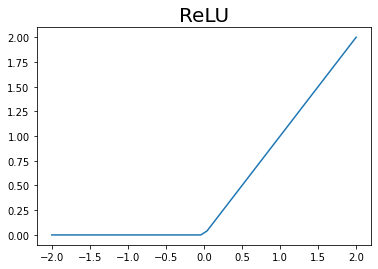

In [29]:
x = np.linspace(-2, 2, 50)
plt.plot(x, np.maximum(x, 0))
plt.title("ReLU", fontsize=20)

In [30]:
torch.manual_seed(14)  # For reproducibility
nn_3l = Net_ANN().double()

### Train:

train loss: 30.10280566351927
validation loss: 30.098258320281605
train loss: 19.226915068166928
validation loss: 19.305319879575393
train loss: 12.359938530797095
validation loss: 12.405587604922674
train loss: 8.804113848539592
validation loss: 8.772845231768356
train loss: 7.313973479872491
validation loss: 7.238473853470359
train loss: 6.3469450301187065
validation loss: 6.319096350826312
train loss: 5.538526756073344
validation loss: 5.556763295385036
train loss: 4.813394991072334
validation loss: 4.847590104470933
train loss: 4.266499072095901
validation loss: 4.311467797357489
train loss: 3.932007719744745
validation loss: 3.962713983870609
train loss: 3.7297394749911796
validation loss: 3.736884421444118
train loss: 3.5676713214561118
validation loss: 3.5793860721481874
train loss: 3.407458609749914
validation loss: 3.3990002653181683
train loss: 3.244028932061343
validation loss: 3.2353987769554466
train loss: 3.090135348335602
validation loss: 3.0666057157059363
train loss: 2

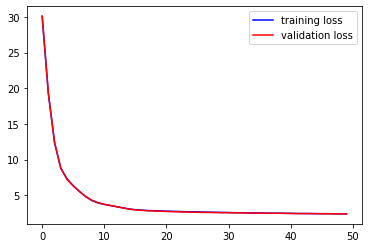

In [31]:
n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.003)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

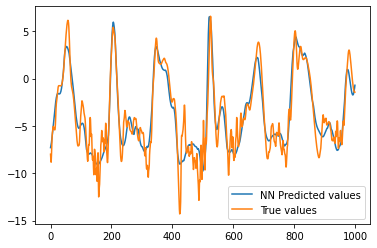

In [32]:
preds22 = nn_3l(torch.from_numpy(Xtrue_test[:, :]).double())
plt.plot(preds22.detach().numpy()[0:1000, 1], label="NN Predicted values")
plt.plot(subgrid_tend_test[:1000, 1], label="True values")

plt.legend();

In [33]:
T_test = 5

# X_full,_,_ = W.run(dt, T_test) # Full model

gcm_net_3layers = GCM_network(Forcing, nn_3l)
Xnn_3layer, t = gcm_net_3layers(init_cond, dt, int(T_test / dt), nn_3l)

gcm_net_1layers = GCM_network(Forcing, lin_net)
Xnn_1layer, t = gcm_net_1layers(init_cond, dt, int(T_test / dt), lin_net)

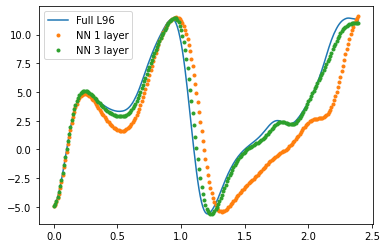

In [34]:
time_i = 240
channel = 1
plt.plot(t[:time_i], X_full[:time_i, channel], label="Full L96")
plt.plot(t[:time_i], Xnn_1layer[:time_i, channel], ".", label="NN 1 layer")
plt.plot(t[:time_i], Xnn_3layer[:time_i, channel], ".", label="NN 3 layer")

plt.legend();

In [35]:
# Checking over 100 different initial conditions...
err1L = list()
err3L = list()
T_test = 1
for i in range(100):
    init_cond_temp = Xtrue[i * 10, :]
    gcm_net_3layers = GCM_network(Forcing, nn_3l)
    Xnn_3layer_tmp, t = gcm_net_3layers(init_cond_temp, dt, int(T_test / dt), nn_3l)

    gcm_net_1layers = GCM_network(Forcing, lin_net)
    Xnn_1layer_tmp, t = gcm_net_1layers(init_cond_temp, dt, int(T_test / dt), lin_net)

    err1L.append(
        np.sum(np.abs(Xtrue[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_1layer_tmp))
    )
    err3L.append(
        np.sum(np.abs(Xtrue[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_3layer_tmp))
    )
print("Sum of errors for 1 layer:", sum(err1L))
print("Sum of errors for 3 layer:", sum(err3L))

Sum of errors for 1 layer: 54923.67080166712
Sum of errors for 3 layer: 38844.66949719773


### Training some more to further improve performance

train loss: 2.3936231024535313
validation loss: 2.3896569628689304
train loss: 2.393561931044336
validation loss: 2.401244477647103
train loss: 2.391097420340776
validation loss: 2.374780507752218
train loss: 2.3792471410989315
validation loss: 2.3751685740614352
train loss: 2.376406130650605
validation loss: 2.362020734797524
train loss: 2.3783412703342375
validation loss: 2.372504322184249
train loss: 2.369729080427871
validation loss: 2.3730899778632764
train loss: 2.370013719258518
validation loss: 2.3763521028447836
train loss: 2.35573397976726
validation loss: 2.366753936236434
train loss: 2.352748054637433
validation loss: 2.355310623356801
train loss: 2.3501579946478404
validation loss: 2.364827865549984
train loss: 2.3464917284711424
validation loss: 2.3512789090789408
train loss: 2.341625038090568
validation loss: 2.349775634505426
train loss: 2.339385619382255
validation loss: 2.3336904731560058
train loss: 2.3420137852870018
validation loss: 2.336359842496002
train loss: 2.

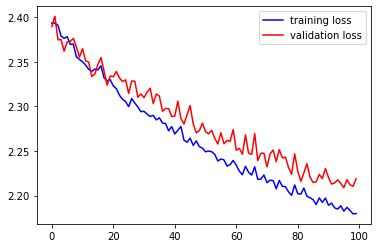

In [36]:
n_epochs = 100  # Number of epocs
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

In [37]:
# Save network
PATH = "network_3_layers_100_epoches.pth"
torch.save(nn_3l.state_dict(), PATH)

# Load network
# path_load = 'network_3_layers_100_epoches.pth'
# nn_3l.load_state_dict(torch.load(path_load))

# Regularization and overfitting

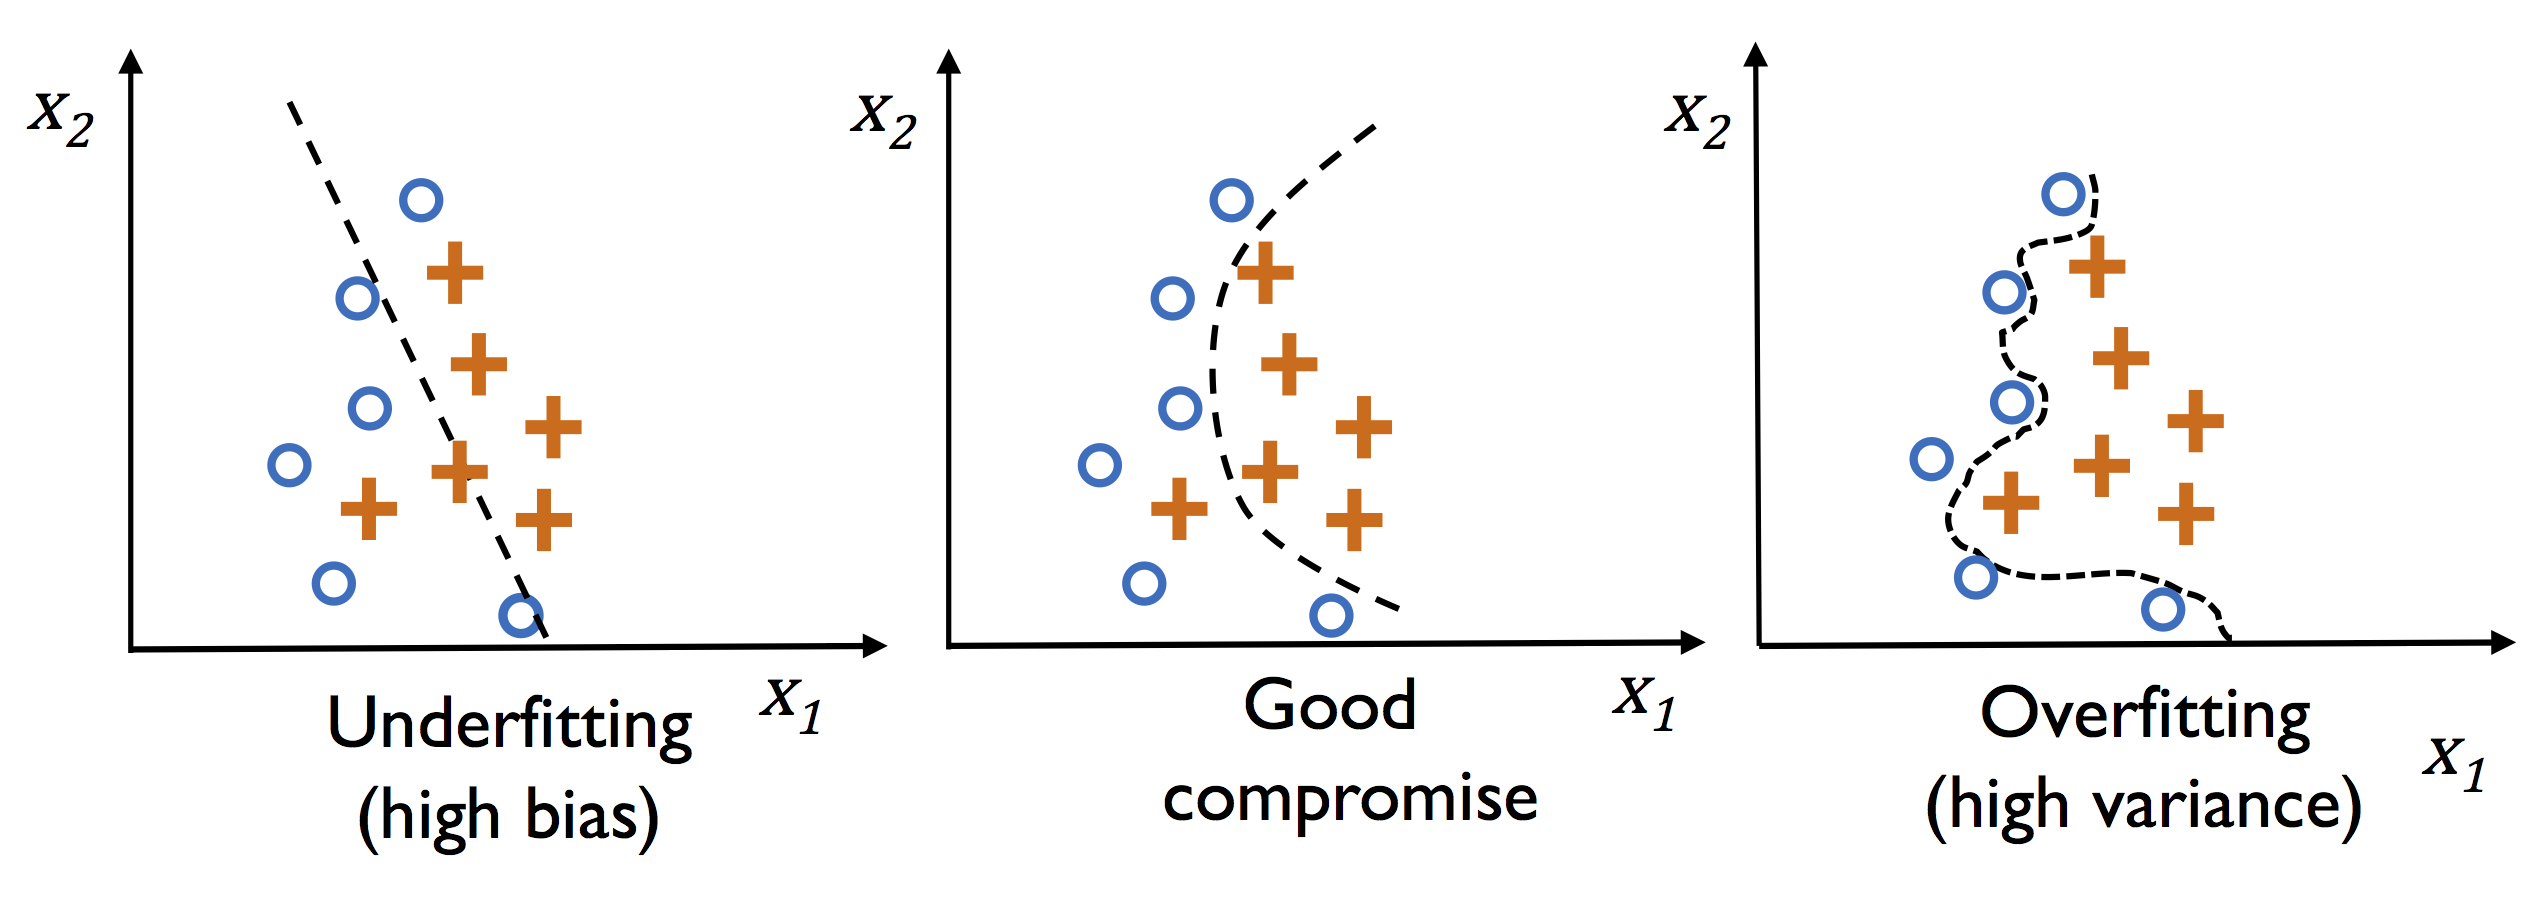

In [38]:
from IPython.display import Image

Image(filename="figs/overfitting.png", width=700)
# The figure below is taken from Python Machine Learning book by Sebastian Raschka

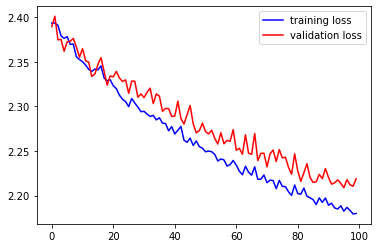

In [39]:
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

### Regularization methods are aimed to tackle overfitting. 

For example, the model on the far right of the plot predicts perfectly on the given set, yet it's not the best choice. Why is that? If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.



All ML algorithms has some form of regularization. 

### Useful ways to think of regularization:
- #### Putting constraints on the model
aiming to have a better generalizability (avoid modeling the noise or ''remember'' training data). 
- #### Adding a term to the loss function so that: Loss = TrainingLoss + Regularization
put a penalty for making the model more complex. 


Very braodly speaking (just to gain intuition) - if we want to reduce the training loss (reduce bias) we should try using a more complex model (if we have enough data) and if we want to reduce overfitting (reduce variace) we should simplify or constraint the model we use (increasing regularization). 


# Regularization of Neural Networks

- Dropout (added in the definition of the network). 
- Early stopping
- weight decay (added in the optimizer part - see ?optim.Adam)
- Data augmentation (usually for images)

#### Weight decay (L2 norm)

weight decay is usually defined as a term that’s added directly to the update rule.
Namely, to update a certain weight $w$ in the $i+1$ iteration, we would use a modified rule:

$w_{i+1} = w_{i} - \gamma ( \frac{\partial L}{\partial w} + A w_{i})$

In practice, this is almost identical to L_2 regularization, though there is some difference (e.g., see [here](https://bbabenko.github.io/weight-decay/))

Weight decay is one of the parameters of the optimizer - try ?torch.optim.SGD

### Add a weight decay to a network and try to train it again

train loss: 2.2314384903838413
validation loss: 2.2782309564270973
train loss: 2.2120416453347524
validation loss: 2.2444237422103157
train loss: 2.233534893261558
validation loss: 2.2685620758703635
train loss: 2.2372110910297756
validation loss: 2.268336719948899
train loss: 2.2499979459620727
validation loss: 2.2708776370083528
train loss: 2.2592691313816986
validation loss: 2.295985790072842
train loss: 2.2672926172865875
validation loss: 2.2924298426865404
train loss: 2.277997307787811
validation loss: 2.2944433457301203
train loss: 2.277924751032858
validation loss: 2.2946253242791252
train loss: 2.2869389154573487
validation loss: 2.3143975321770642


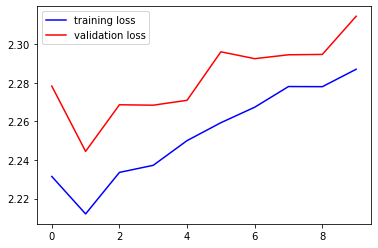

In [40]:
n_epochs = 10  # Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.003, weight_decay=0.1)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

#### Dropout

By dropping a unit out, we mean temporarily removing it from the network while training, along with all its incoming and outgoing connections. 
See more details [here](http://jmlr.org/papers/v15/srivastava14a.html).
It is usually the most useful regularization that we can do in fully connected layers

In convolutional layers dropout makes less sense - see more discussion [here](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html)


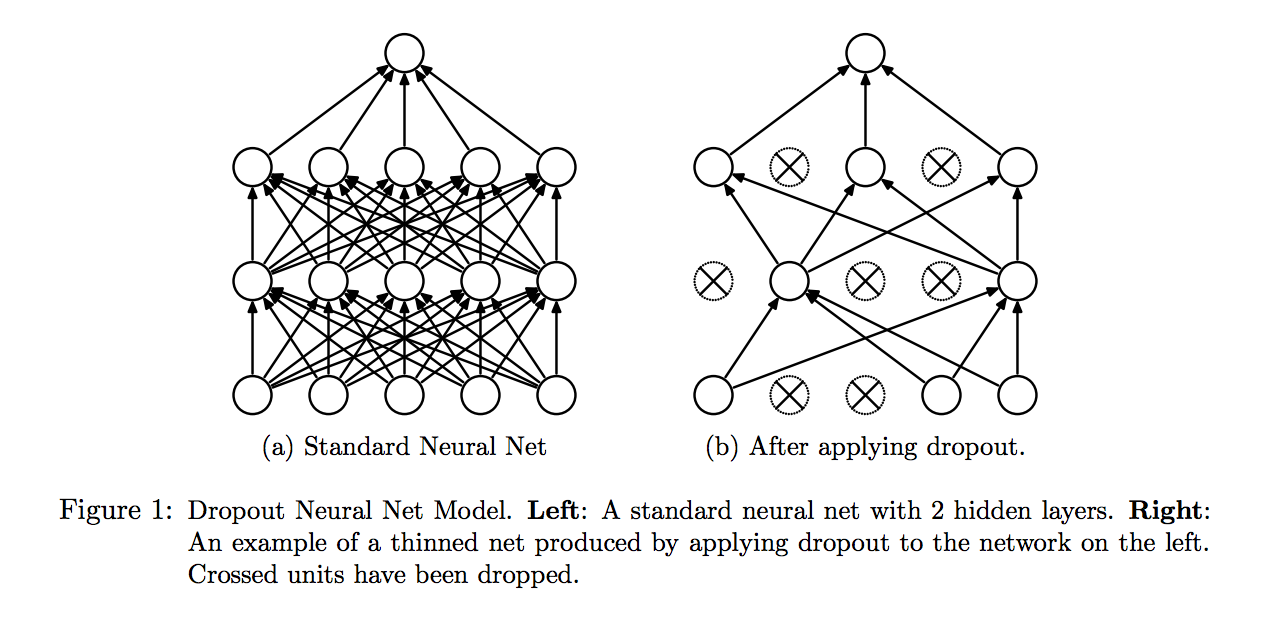

In [41]:
# Image taken from: http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
Image(filename="figs/Dropout_layer.png", width=700)

In [42]:
# define network structure in pytorch


class Net_ANN_dropout(nn.Module):
    def __init__(self, dropout=0.2):
        super(Net_ANN_dropout, self).__init__()
        self.linear1 = nn.Linear(8, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)
        self.drop = nn.Dropout(dropout)  # regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = self.drop(x)
        x = FF.relu(self.linear2(x))
        x = self.drop(x)
        x = self.linear3(x)
        return x

train loss: 26.234668584238296
validation loss: 26.155322406535845
train loss: 23.514418100122924
validation loss: 23.555070345373043
train loss: 21.346142569808556
validation loss: 21.35843211497852
train loss: 20.096765439709788
validation loss: 20.093127403366047
train loss: 19.0512944214022
validation loss: 19.096516373902453
train loss: 18.425282193580724
validation loss: 18.49370628751133
train loss: 17.606429947576768
validation loss: 17.679004679052614
train loss: 16.967120129781623
validation loss: 17.05890202392759
train loss: 16.793542839199613
validation loss: 16.893182489584653
train loss: 16.508778103517187
validation loss: 16.622046200213


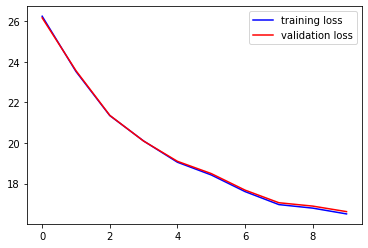

In [43]:
nn_3l_drop = Net_ANN_dropout(dropout=0.8).double()  # Exagerated dropout...
n_epochs = 10  # Number of epocs
optimizer = optim.Adam(nn_3l_drop.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_drop, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_drop, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_drop, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

# How to choose a learning rate?

### Visuzlization of the loss function

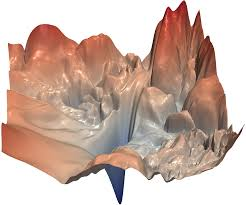

In [44]:
# Image taken from: https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf
Image(filename="figs/Loss_function_vis_NN.jpeg", width=400)

## Finding an optimal learning rate

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E-02


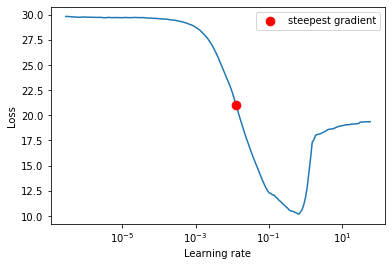

In [45]:
nn_3l_LR = Net_ANN().double()
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=1e-7)
lr_finder = LRFinder(nn_3l_LR, optimizer, criterion)
lr_finder.range_test(loader, end_lr=100, num_iter=200)
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()  # to reset the model and optimizer to their initial state

train loss: 10.345711413910546
validation loss: 10.290493650178423
train loss: 6.4205262008395705
validation loss: 6.322531737778826
train loss: 4.930118045235596
validation loss: 4.986968884536958
train loss: 3.664487281786251
validation loss: 3.7530310180380906
train loss: 3.136619516550249
validation loss: 3.244453601398812
train loss: 2.913189844045152
validation loss: 2.968798757967583
train loss: 2.7696742217186148
validation loss: 2.8252908486447237
train loss: 2.6858373294996793
validation loss: 2.73287962758235
train loss: 2.6209540893287584
validation loss: 2.6553098130084853
train loss: 2.5597641637302506
validation loss: 2.5862131988480668
train loss: 2.521054734332254
validation loss: 2.54256435916044
train loss: 2.5021962852781443
validation loss: 2.5256157255910967
train loss: 2.458701407358389
validation loss: 2.514253125571478
train loss: 2.429087602798124
validation loss: 2.478867453026006
train loss: 2.4271984333203562
validation loss: 2.4747383216145344
train loss: 

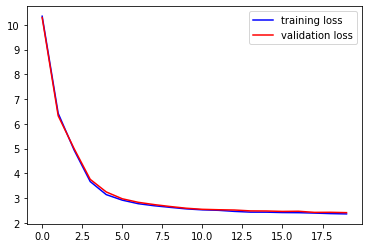

In [46]:
n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_LR, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_LR, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_LR, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

### We converged much faster than before. 

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.44E-03


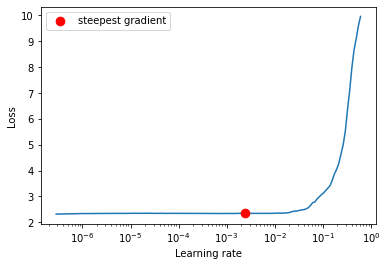

In [47]:
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=1e-7)
lr_finder = LRFinder(nn_3l_LR, optimizer, criterion)
lr_finder.range_test(loader, end_lr=100, num_iter=200)
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()  # to reset the model and optimizer to their initial state

train loss: 2.3417850146349997
validation loss: 2.3948197999622116
train loss: 2.3410854408157507
validation loss: 2.3964944712345684
train loss: 2.337502518569003
validation loss: 2.386210716391651
train loss: 2.3351061984836727
validation loss: 2.3877206107963826
train loss: 2.3320390005606018
validation loss: 2.3898566292883756
train loss: 2.3233566579921368
validation loss: 2.3799686334655457
train loss: 2.321871101795828
validation loss: 2.372481454368107
train loss: 2.321980799927395
validation loss: 2.3831954384426495
train loss: 2.3156235256583066
validation loss: 2.365812883491638
train loss: 2.3126986381855836
validation loss: 2.3774256322994374


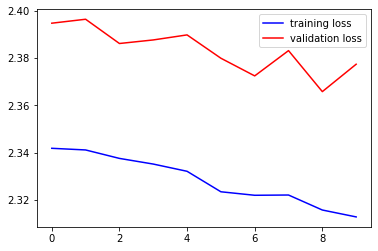

In [48]:
n_epochs = 10  # Number of epocs
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=0.001)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_LR, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_LR, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_LR, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

## I won't talk about but I recommend reading:

## BatchNormalization 

Normalize the activation values such that the hidden representation doesn’t vary drastically and also helps us to get improvement in the training speed.

## Cyclic learning rate

### To understand cyclic learning rates and the One cycle policy - read more [here](https://sgugger.github.io/the-1cycle-policy.html)

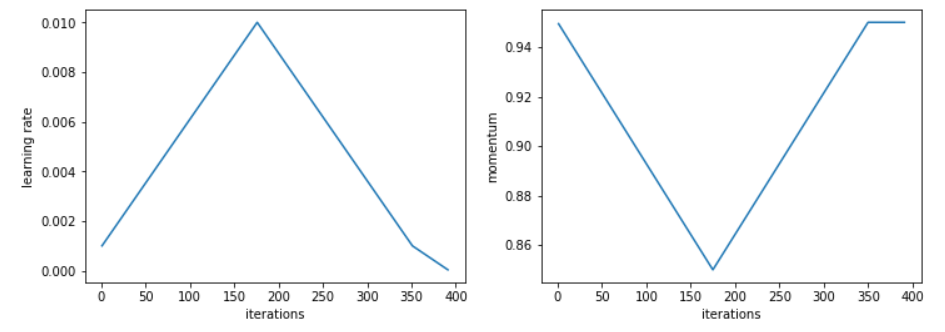

In [49]:
# Image taken from - https://docs.fast.ai/callbacks.one_cycle.html
Image(filename="figs/onecycle_params.png", width=700)

To use cyclic learning rates: ?optim.lr_scheduler.CyclicLR